In [1]:
import mlflow
import xarray as xr
import matplotlib.pyplot as plt
from utils import select_experiment, select_run
import os

%env MLFLOW_TRACKING_URI /scratch/ag7531/mlruns

env: MLFLOW_TRACKING_URI=/scratch/ag7531/mlruns


In [2]:
def load_data_from_run(i_run: int):
    run = runs.iloc[i_run]
    filenames = os.listdir(run['artifact_uri'])
    datasets = []
    for fn in filenames:
        print(f'Loading {fn}')
        name = fn.split('_')[0]
        datasets.append(xr.open_dataset(os.path.join(run['artifact_uri'], fn)))
    return datasets

In [3]:
exp_id, _ = select_experiment(default_selection='22')
runs=mlflow.search_runs(experiment_ids=(exp_id,))

7 :  Unet
21 :  modelsv1
6 :  multiregion
3 :  multiregions
19 :  data-global
14 :  forcingdatav3
17 :  meeting22july
5 :  regionsfortraining
2 :  training
23 :  Default
4 :  default
13 :  forcingdatav2
16 :  meeting15july
22 :  parameterized
20 :  test_global
9 :  forcingdata1pct
12 :  test
15 :  datacm21
8 :  arctan
18 :  forcing-data-global
Select the id of an experiment: 


In [4]:
datasets = load_data_from_run(0)

Loading u_eddy_permitting_0001.nc
Loading du_eddy_permitting_0001.nc
Loading dv_eddy_permitting_0001.nc
Loading eta_eddy_permitting_0001.nc
Loading v_eddy_permitting_0001.nc


In [5]:
u = datasets[0]
v = datasets[4]
eta = datasets[3]
u = u.interp(dict(x=eta.x, y=eta.y))
v = v.interp(dict(x=eta.x, y=eta.y))

In [6]:
uv_high_rez = xr.merge((u, v)).rename(dict(x='xu_ocean', y='yu_ocean', t='time', u='usurf', v='vsurf'))

In [7]:
uv_high_rez

<xarray.Dataset>
Dimensions:   (time: 3599, xu_ocean: 384, yu_ocean: 384)
Coordinates:
  * time      (time) float64 8.627e+04 1.727e+05 ... 3.109e+08 3.11e+08
  * xu_ocean  (xu_ocean) float64 5e+03 1.5e+04 2.5e+04 ... 3.825e+06 3.835e+06
  * yu_ocean  (yu_ocean) float64 5e+03 1.5e+04 2.5e+04 ... 3.825e+06 3.835e+06
Data variables:
    usurf     (time, yu_ocean, xu_ocean) float64 nan -0.0005151 ... nan
    vsurf     (time, yu_ocean, xu_ocean) float64 nan nan nan nan ... nan nan nan

In [8]:
from data.coarse import eddy_forcing
import numpy as np

In [9]:
dxu = xr.DataArray(dims=('xu_ocean', 'yu_ocean'), data=np.ones((384, 384)) * 1e4,
                  coords=dict(xu_ocean=uv_high_rez.xu_ocean, yu_ocean=uv_high_rez.yu_ocean))
dyu = xr.DataArray(dims=('xu_ocean', 'yu_ocean'), data=np.ones((384, 384)) * 1e4,
                  coords=dict(xu_ocean=uv_high_rez.xu_ocean, yu_ocean=uv_high_rez.yu_ocean))
grid_data = xr.Dataset(dict(dxu=dxu, dyu=dyu))
grid_data

<xarray.Dataset>
Dimensions:   (xu_ocean: 384, yu_ocean: 384)
Coordinates:
  * xu_ocean  (xu_ocean) float64 5e+03 1.5e+04 2.5e+04 ... 3.825e+06 3.835e+06
  * yu_ocean  (yu_ocean) float64 5e+03 1.5e+04 2.5e+04 ... 3.825e+06 3.835e+06
Data variables:
    dxu       (xu_ocean, yu_ocean) float64 1e+04 1e+04 1e+04 ... 1e+04 1e+04
    dyu       (xu_ocean, yu_ocean) float64 1e+04 1e+04 1e+04 ... 1e+04 1e+04

In [10]:
uv_high_rez = uv_high_rez.chunk(dict(time=500))

In [11]:
template=uv_high_rez.coarsen(dict(xu_ocean=4, yu_ocean=4)).mean()
template = xr.merge((template, template.rename(dict(usurf='S_x', vsurf='S_y'))))
low_rez = xr.map_blocks(lambda x: eddy_forcing(x, grid_data, 4), uv_high_rez,
                        template=template)

In [12]:
low_rez.nbytes / 1e9

1.061418616

In [13]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    low_rez = low_rez.compute()

[##                                      ] | 6% Completed |  0.4sUsing factor mode
[##                                      ] | 6% Completed | 49.4sscale factor:  4
[#######                                 ] | 18% Completed | 53.9sUsing factor mode
[#######                                 ] | 18% Completed |  1min 42.9sscale factor:  4
[############                            ] | 31% Completed |  1min 47.4sUsing factor mode
[############                            ] | 31% Completed |  2min 36.4sscale factor:  4
[#################                       ] | 43% Completed |  2min 40.9sUsing factor mode
[#################                       ] | 43% Completed |  3min 29.9sscale factor:  4
[######################                  ] | 56% Completed |  3min 34.3sUsing factor mode
[######################                  ] | 56% Completed |  4min 23.3sscale factor:  4
[###########################             ] | 68% Completed |  4min 27.8sUsing factor mode
[###########################       

In [14]:
low_rez

<xarray.Dataset>
Dimensions:   (time: 3599, xu_ocean: 96, yu_ocean: 96)
Coordinates:
  * time      (time) float64 8.627e+04 1.727e+05 ... 3.109e+08 3.11e+08
  * xu_ocean  (xu_ocean) float64 2e+04 6e+04 1e+05 ... 3.78e+06 3.82e+06
  * yu_ocean  (yu_ocean) float64 2e+04 6e+04 1e+05 ... 3.78e+06 3.82e+06
Data variables:
    usurf     (time, yu_ocean, xu_ocean) float64 -0.001499 ... 0.0009649
    vsurf     (time, yu_ocean, xu_ocean) float64 0.001475 ... -0.0003283
    S_x       (time, yu_ocean, xu_ocean) float64 nan nan ... 1.832e-10 3.368e-11
    S_y       (time, yu_ocean, xu_ocean) float64 nan nan ... 9.307e-10 2.972e-10

<IPython.core.display.Javascript object>


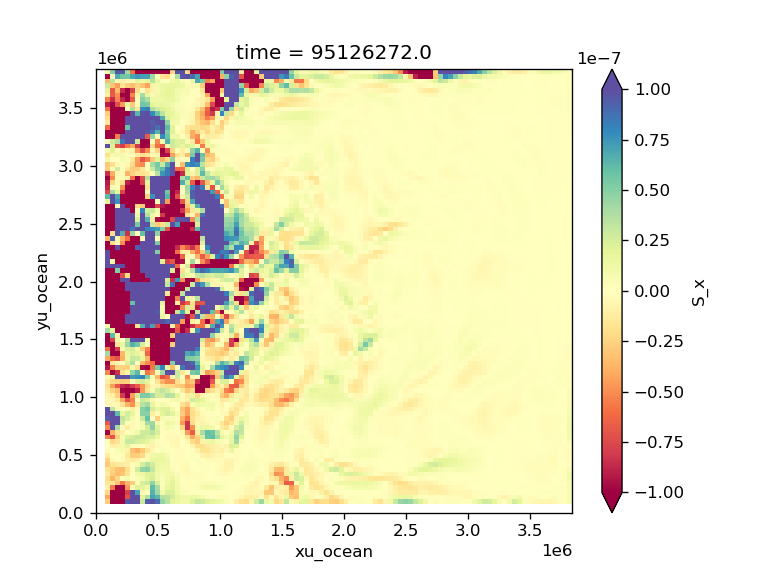

In [15]:
%matplotlib notebook
low_rez['S_x'].isel(time=1100).plot(vmin=-1e-7, vmax=1e-7, cmap='Spectral')

In [16]:
from models.models1 import FullyCNN
net = FullyCNN(padding='same')


In [17]:
net

FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [18]:
import pickle
def pickle_artifact(run_id: str, path: str):
    client = mlflow.tracking.MlflowClient()
    file = client.download_artifacts(run_id, path)
    f = open(file, 'rb')
    return pickle.load(f)

client = mlflow.tracking.MlflowClient()

models_experiment_id, _ = select_experiment()
cols = ['metrics.test loss', 'start_time', 'params.time_indices',
        'params.model_cls_name', 'params.source.run_id', 'params.submodel']
model_run = select_run(sort_by='start_time', cols=cols,
                       experiment_ids=[models_experiment_id, ])
model_file = client.download_artifacts(model_run.run_id,
                                       'models/trained_model.pth')
transformation = pickle_artifact(model_run.run_id, 'models/transformation')
net.final_transformation = transformation

7 :  Unet
21 :  modelsv1
6 :  multiregion
3 :  multiregions
19 :  data-global
14 :  forcingdatav3
17 :  meeting22july
5 :  regionsfortraining
2 :  training
23 :  Default
4 :  default
13 :  forcingdatav2
16 :  meeting15july
22 :  parameterized
20 :  test_global
9 :  forcingdata1pct
12 :  test
15 :  datacm21
8 :  arctan
18 :  forcing-data-global
Select the id of an experiment: 21
                              run_id experiment_id  metrics.test loss  \
0   dc74cea68a7f4c7e98f9228649a97135            21          -1.978643   
1   ec38e81123804b318c65b2c055667cbe            21                NaN   
2   d5089bb089004bdf8c7de3831fc745ed            21          -1.905384   
3   2c646c84f25b46e69fa2b323ef9eb132            21          -1.897243   
4   7b828ab254a24c5b92557e78f601bd4f            21          -1.907832   
5   454771c464a145dcaf75a786632976ef            21          -1.887052   
6   4e8e899e198a4ea5b50f27555d19b97e            21          -1.910706   
7   3d858e5733cb4de99c8fdba1ca8f6b0

In [19]:
import torch
net.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [20]:
net

FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final_transformation): SoftPlusTransform(Parameter containing:
  tensor(-0.1793, device='cuda:0', requires_grad=True))
)

In [21]:
device = torch.device('cuda')
from train.losses import HeteroskedasticGaussianLossV2

In [22]:
criterion = HeteroskedasticGaussianLossV2(n_target_channels=2)

In [23]:
from testing.utils import create_large_test_dataset
from torch.utils.data import DataLoader

In [24]:
from data.datasets import (RawDataFromXrDataset, DatasetTransformer,
                           Subset_, DatasetWithTransform, ComposeTransforms,
                           MultipleTimeIndices, DatasetPartitioner)
dataset = RawDataFromXrDataset(low_rez * 10.)
dataset.index = 'time'
dataset.add_input('usurf')
dataset.add_input('vsurf')
dataset.add_output('S_x')
dataset.add_output('S_y')
features_transform_ = ComposeTransforms()
targets_transform_ = ComposeTransforms()
transform = DatasetTransformer(features_transform_, targets_transform_)
transform.fit(dataset)
dataset = DatasetWithTransform(dataset, transform)
test = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device)
test = test.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))

In [25]:
with ProgressBar():
    test = test.compute()

[########################################] | 100% Completed | 24.3s


In [26]:
test

<xarray.Dataset>
Dimensions:   (time: 3599, xu_ocean: 96, yu_ocean: 96)
Coordinates:
  * time      (time) float64 8.627e+04 1.727e+05 ... 3.109e+08 3.11e+08
  * yu_ocean  (yu_ocean) float64 2e+04 6e+04 1e+05 ... 3.78e+06 3.82e+06
  * xu_ocean  (xu_ocean) float64 2e+04 6e+04 1e+05 ... 3.78e+06 3.82e+06
Data variables:
    S_x       (time, yu_ocean, xu_ocean) float32 -0.03139 -0.01223 ... 0.0004114
    S_y       (time, yu_ocean, xu_ocean) float32 -0.0231 -0.047 ... -0.04542
    S_xscale  (time, yu_ocean, xu_ocean) float32 49.98 74.18 ... 54.09 42.14
    S_yscale  (time, yu_ocean, xu_ocean) float32 55.63 90.1 105.8 ... 52.26 39.4

<IPython.core.display.Javascript object>


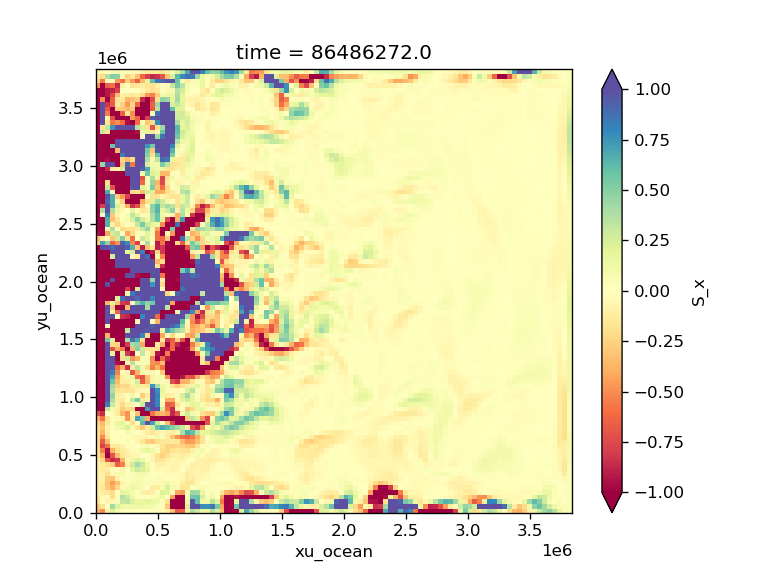

In [27]:
plt.figure()
test.isel(time=1000)['S_x'].plot(vmin=-1, vmax=1, cmap='Spectral')

<IPython.core.display.Javascript object>


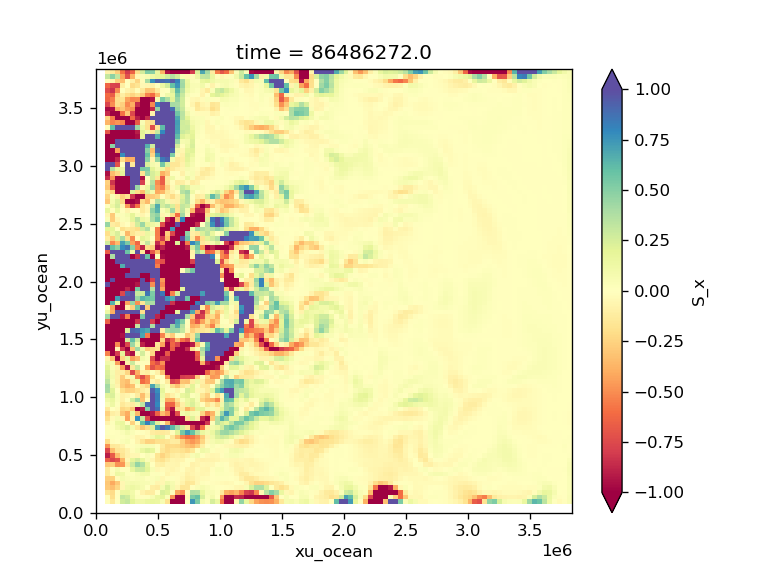

In [28]:
plt.figure()
(low_rez.isel(time=1000)['S_x']*1e7).plot(vmin=-1, vmax=1, cmap='Spectral')

<IPython.core.display.Javascript object>


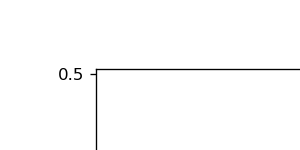

In [29]:
from scipy.stats import norm
plt.figure()
((low_rez['S_x']*1e7 - test['S_x'])
 * (test['S_xscale'])).plot.hist(bins=np.linspace(-4, 4, 100), density=True)
plt.plot(np.linspace(-4, 4, 100), norm.pdf(np.linspace(-4, 4, 100)))

<IPython.core.display.Javascript object>


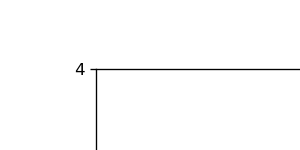

In [30]:
plt.figure()
for i, var in enumerate(['S_x', 'S_y']):
    residuals_t = ((low_rez[var]*1e7 - test[var]) * (test[f'{var}scale']))
    quantiles = np.linspace(0., 1., 100)
    norm_quantiles = norm.ppf(quantiles)
    obs_quantiles = np.nanquantile(residuals_t.values[::20, ::, ::], quantiles)
    plt.subplot(1, 2, i + 1)
    plt.plot(norm_quantiles, norm_quantiles, 'gray')
    plt.plot(norm_quantiles, obs_quantiles, 'k*')
    plt.ylim(-4, 4)
    plt.yticks(np.arange(-4, 5, 2))

In [31]:
plt.savefig('offline_test_swm1.jpg', dpi=400)

In [32]:
mse = dict()
variance = dict()
r_squared = dict()
correlation = dict()
for var in ['S_x', 'S_y']:
    mse[var] = ((test[var] - low_rez[var]*1e7)**2).mean(dim='time')
    variance[var] = ((low_rez[var]*1e7)**2).mean(dim='time')
    r_squared[var] = 1 - mse[var] / variance[var]
    correlation[var] = xr.corr(test[var], low_rez[var]*1e7, dim='time')

/ext3/miniconda3/envs/subgrid/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/ext3/miniconda3/envs/subgrid/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/ext3/miniconda3/envs/subgrid/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/ext3/miniconda3/envs/subgrid/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


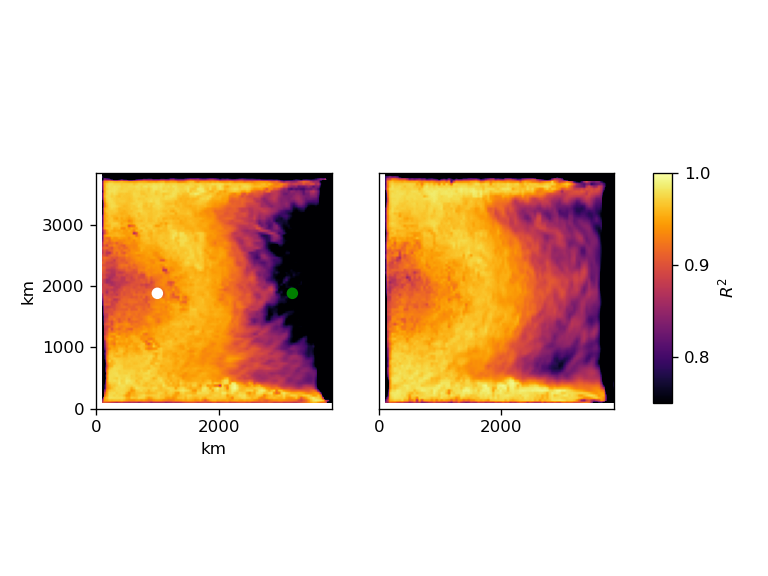

In [36]:
from matplotlib.patches import Arrow, Circle
fig = plt.figure()
extent = (0, 3840, 0, 3840)
for i, var in enumerate(['S_x', 'S_y']):
    plt.subplot(1, 2, i + 1)
    im = plt.imshow(r_squared[var].values, vmin=0.75, vmax=1, cmap='inferno',
                   origin='lower', extent=extent)
    im.axes.set_xticks([2000])
    if i > 0:
        im.axes.set_yticks([])
    else:
        im.axes.set_yticks([0, 1000, 2000, 3000])
    im.axes.set_xticks([0, 2000])
    if i == 0:
        im.axes.set_xlabel('km')
        im.axes.set_ylabel('km')
        patches = [Circle((25*40, 47*40), radius=2*40, color='white'),
                   Circle((80*40, 47*40), radius=2*40, color='green')]
        for patch in patches:
            im.axes.add_patch(patch)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.025, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label=r'$R^2$', ticks=[0.8, 0.9, 1])

In [37]:
plt.savefig('offline_test_swm2.jpg', dpi=400)

80   47


<IPython.core.display.Javascript object>


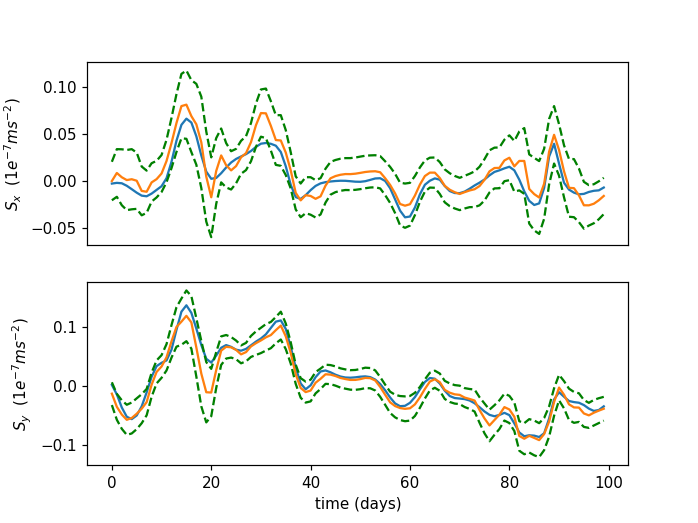

In [174]:
%matplotlib notebook
x = 80
y = 47
print(x, ' ', y)
plt.figure()
for i, var in enumerate(['S_x', 'S_y']):
    ax = plt.subplot(2, 1, i + 1)
    plt.plot(low_rez[var].isel(xu_ocean=x, yu_ocean=y, time=slice(2000, 2100))*1e7)
    plt.plot(test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(2000, 2100)))
    ub = (test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(2000, 2100))
          + 1.96 / test[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(2000, 2100)))
    lb = (test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(2000, 2100))
          - 1.96 / test[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(2000, 2100)))
    plt.plot(ub, '--g')
    plt.plot(lb, '--g')
    if i == 0:
        ax.set_xticks([])
    if i == 1:
        plt.xlabel('time (days)')
    plt.ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')

In [175]:
plt.savefig(f"offline_test_swm3x={x}-y={y}.jpg", dpi=400)

<IPython.core.display.Javascript object>


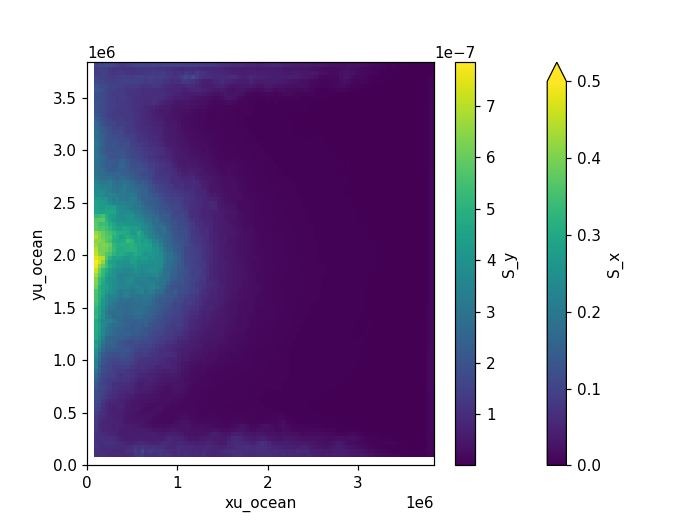

/ext3/miniconda3/envs/subgrid/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [106]:
plt.figure()
#((low_rez['S_y']*1e7 - test['S_y']).median(dim='time') ).plot()
#residuals_t.median(dim='time').plot(vmin=0, vmax=1)
(abs(((low_rez['S_x']*1e7 - test['S_x'])).mean(dim='time') / (low_rez['S_x']*1e7).std(dim='time'))).plot(vmin=0, vmax=0.5)

<IPython.core.display.Javascript object>


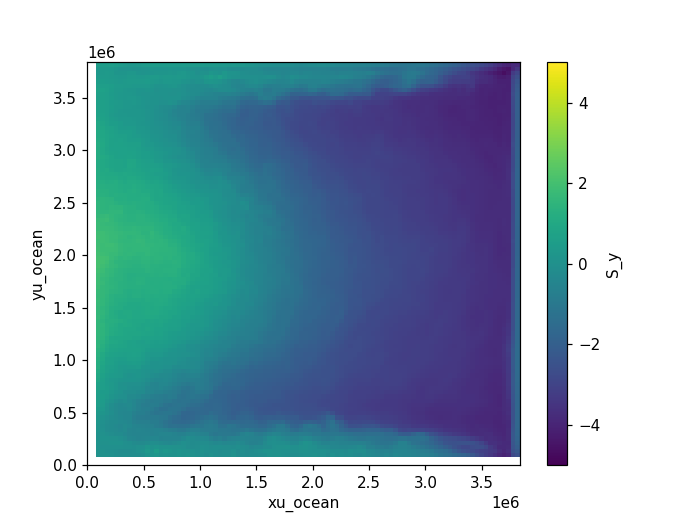

/ext3/miniconda3/envs/subgrid/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [112]:
plt.figure()
(np.log((low_rez['S_y']*1e7).std(dim='time'))).plot(vmin=-5, vmax=5)

In [117]:
low_rez['S_y'].isel(xu_ocean=slice(45, None)).std()

<xarray.DataArray 'S_y' ()>
array(1.75631954e-08)